# Tick, Volume and Dollar Bar 

Using as a reference the exercise 2.1 of AFML in this notebook we will create time, volume and dollar bars starting from tick data. We will compare how they statistically behave and which of the three methods create the most stable bars

## Import Libraries

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Import and Check Data

In [3]:
print(os.listdir('../data'))
data = pd.read_csv('../data/SP_futures_tick_data.csv')
data.shape

['btc_1h_data_2018_to_2025.csv', 'SP_futures_tick_data.csv']


(13802502, 4)

The data frame is huge hence I will only select a subset of, say, five years

In [4]:
print(f"data starts at {data.date.iloc[0]} and ends at {data.date.iloc[-1]}")
#select only data between 2014 and 2018
#combine 'date' and 'time' strings into one column
datetime_str = data['date'] + ' ' + data['time']
# Use dayfirst=True if your dates are day/month/year format
data['datetime'] = pd.to_datetime(datetime_str, errors='coerce')

data starts at 01/03/2000 and ends at 12/31/2019


In [5]:
#after 2013
data = data[data.datetime.dt.year >= 2014]
#before 2019
data = data[data.datetime.dt.year <= 2018]
#fiannly drop date and time 
data = data.drop(['date','time'],axis=1)
print(f'Now, data starts at {data.datetime.iloc[0]} and ends at {data.datetime.iloc[-1]}')
data = data.reset_index()

Now, data starts at 2014-01-02 05:00:00.028000 and ends at 2018-12-31 15:49:46.582000


Now, let's check if the roll is already implemented by the data provider (yahoo finance)

In [6]:
#take unique month like 06-2016 ... 06-2017 are unique
data['date_only'] = data['datetime'].dt.date
data['month'] = data['datetime'].dt.to_period('M')  
data = data.sort_values('datetime')
limit = 3

roll_candidates = []

#iterate over each unique month to check whihc day on that month has the most high price jumps
for month in data['month'].unique():

    month_data = data[data['month'] == month].copy()
    month_data['price_change'] = month_data['price'].diff()
    std = month_data['price_change'].std()

    #flag jumps: abs(change) > limit * std
    month_data['is_jump'] = month_data['price_change'].abs() > (limit * std)

    #count jumps per day
    jumps_per_day = month_data.groupby('date_only')['is_jump'].sum()

    #find the day with the highest jump count
    if not jumps_per_day.empty:
        max_jump_day = jumps_per_day.idxmax()
        max_jump_count = jumps_per_day.max()
        roll_candidates.append((str(month), max_jump_day, max_jump_count))

#result DataFrame
roll_df = pd.DataFrame(roll_candidates, columns=['Month', 'Max_Jump_Day', 'Jump_Count'])
#get just the day of the month when the max jump occurred to have a ditribution
roll_df['Max_Jump_Day_Of_Month'] = pd.to_datetime(roll_df['Max_Jump_Day']).dt.day
roll_df.head()

,Month,Max_Jump_Day,Jump_Count,Max_Jump_Day_Of_Month
0,2014-01,2014-01-29,86,29
1,2014-02,2014-02-03,54,3
2,2014-03,2014-03-03,23,3
3,2014-04,2014-04-15,55,15
4,2014-05,2014-05-07,45,7


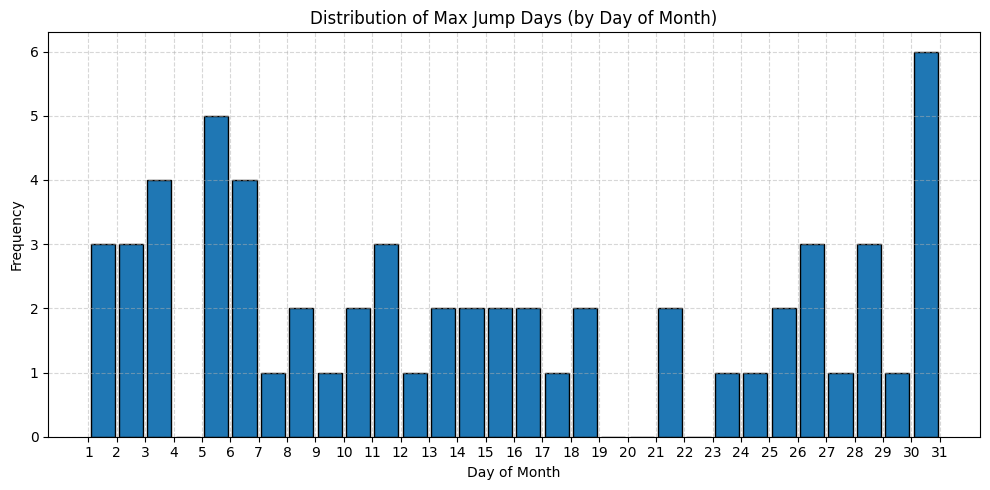

In [7]:
#histogram
plt.figure(figsize=(10, 5))
roll_df['Max_Jump_Day_Of_Month'].plot(
    kind='hist',
    bins=range(1, 32),  # Days 1 to 31
    rwidth=0.85,
    edgecolor='black'
)

plt.title('Distribution of Max Jump Days (by Day of Month)')
plt.xlabel('Day of Month')
plt.ylabel('Frequency')
plt.xticks(range(1, 32))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


There is no a clear day with big price jumps, we can conclude that the assumption that the data have already been adjusted for rolling is true. 

We can finally start the exercise :)

In [8]:
data.head()
#remove the index column (index of the starting full df)
data = data.drop('index',axis=1)

In [9]:
#calling my functions for bar calculations
sys.path.append('../scripts')
from AFML_my_scripts import TickBarsDf,VolumeBarsDf, VolumeBarsDfVectorized, DollarBarsDfVectorized

tick_df = TickBarsDf(data,100)
volume_df = VolumeBarsDfVectorized(data,120)
dollar_df = DollarBarsDfVectorized(data,250000)

print("Let's make sure the fd have more or less the same number of bar for a better comparison")
print(f'len tick df {tick_df.shape[0]}, len volume df {volume_df.shape[0]}, len dollar df {dollar_df.shape[0]}')

Let's make sure the fd have more or less the same number of bar for a better comparison
len tick df 5095, len volume df 5198, len dollar df 5164


In [10]:
tick_df['weeks'] = tick_df.end_date.dt.to_period('W').astype(str)
volume_df['weeks'] = volume_df.end_date.dt.to_period('W').astype(str)
dollar_df['weeks'] = dollar_df.end_date.dt.to_period('W').astype(str)

tick_df_bars_per_week = tick_df.groupby('weeks').size()
volume_df_bars_per_week = volume_df.groupby('weeks').size()
dollar_df_bars_per_week = dollar_df.groupby('weeks').size()

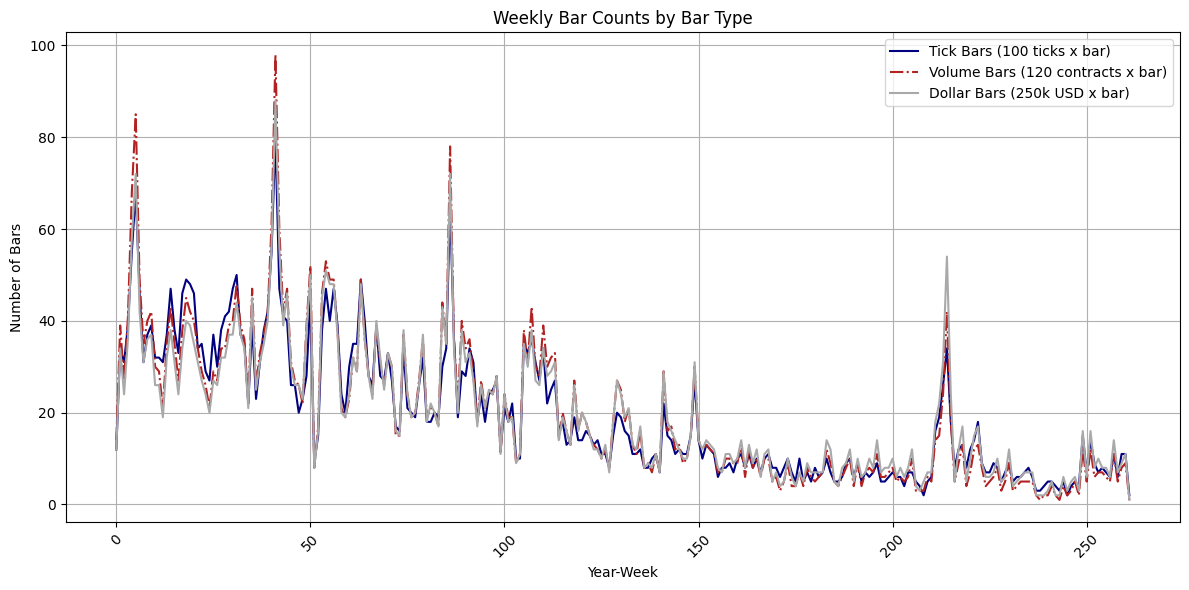

In [11]:
plt.figure(figsize=(12,6))

plt.plot(tick_df_bars_per_week.values, label = 'Tick Bars (100 ticks x bar)', color = 'navy')
plt.plot(volume_df_bars_per_week.values, label = 'Volume Bars (120 contracts x bar)', color = 'firebrick', linestyle = '-.')
plt.plot(dollar_df_bars_per_week.values, label = 'Dollar Bars (250k USD x bar)', color = 'darkgray')

plt.xticks(rotation=45)
plt.xlabel('Year-Week')
plt.ylabel('Number of Bars')
plt.title('Weekly Bar Counts by Bar Type')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

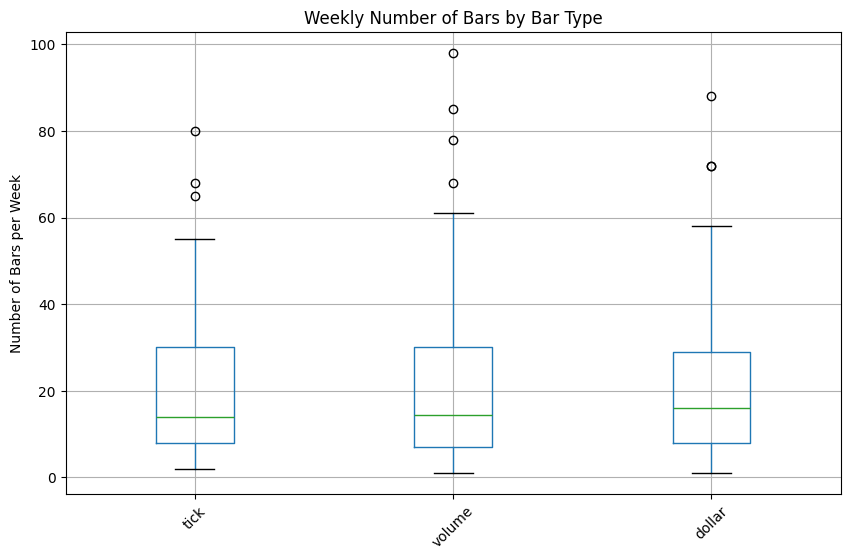

In [12]:
# We also check boxplots to have a look a the distribution ...

bars_per_week_df = pd.DataFrame({
    'tick': tick_df_bars_per_week,
    'volume': volume_df_bars_per_week,
    'dollar': dollar_df_bars_per_week
})
bars_per_week_df = bars_per_week_df.dropna()
plt.figure(figsize=(10,6))
bars_per_week_df.boxplot()
plt.xticks(rotation=45)
plt.ylabel('Number of Bars per Week')
plt.title('Weekly Number of Bars by Bar Type')
plt.show()


The bar count for each week with the three methods is quite correlated. There is no evidence that volume/dollar bars are more stable. Absolutely speaking we notice a drop of the number of bars per week indicating that it requires more time to form a bar and hence the market is less liquid
